># Cacluate seafloor electric ($\mathcal{E}_d$) and magnetic ($\mathcal{H}_d$) fields given a seasurface magnetic field ($\mathcal{H}_o$). This notebook provieds basic calculation of transfer functions needed to calculate $\frac{\mathcal{E}_d}{\mathcal{H}_o}$ and $\frac{\mathcal{H}_d}{\mathcal{H}_o}$ assuming 1D Earth conductivity model.

>- September, 2021. S. Chakraborty (<shibaji7@vt.edu>)

>> ### Simplified 1D Earth conductivity model: conductivity changes with depth only
The models used in this study are SU1 and BM1 ocean model. Following equations from [Boteler et al. (2003)](https://link.springer.com/article/10.1007%2Fs00024-003-2372-6) are used in this study:
$$\frac{\mathcal{E}_d}{\mathcal{H}_o}=Z_d\frac{1}{\cosh{kd}+\frac{Z_d}{Z}\sinh{kd}}$$
$$\frac{\mathcal{H}_d}{\mathcal{H}_o}=\frac{1}{\cosh{kd}+\frac{Z_d}{Z}\sinh{kd}}$$
where: $k=\frac{1+i}{\delta}$, $\delta=\sqrt{\frac{2\rho_s}{\omega\mu_0}}$, thus $kd=(1+i)\frac{d}{\delta}$. Also, $Z,Z_d\sim$ are the characteristic impedence of ocean and seafloor, with $Z=\left(\frac{i\omega\mu_0}{\sigma_s}\right)^{\frac{1}{2}}$, $\sigma_s=\frac{1}{\rho_s}$. $\rho_s$, $d$ are the ocean resistivity and depth, respectively.

>> ## This notebook provides examples of following following operations
* Plots of various transfer functions (TFs), e.g. $\frac{E_d}{E_o}$, $\frac{E_d}{H_o}$, $\frac{H_d}{H_o}$
* Parameters: Ocean depth ($_{ocean}$), sea conductivity ($\rho_s$), seafloor conductivity ($\rho_e$)
* Variations of the TF with frequency, ocean depth, and other parameters under consideration
* Caclulations of seafloor impedance ($Z_d$) considering the Earth as uniform spehere along depth
* Caclulations of seafloor impedance ($Z_d$) considering the Earth as layered spehere along depth

In [1]:
# Import required packages
import bezpy
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])
import numpy as np
from scipy import constants as C

In [2]:
# All the method needed for calculation and plotting
def plot_resistivity(site, ax):
    """
    Method for plotting layerd Earth resistivity model.
    
    Parameters
    ----------
    site: bezpy.mt.site object proving 1D earth model
    ax: matplotlib axis object
    """
    ax.text(0.99, 1.05, "Model: %s"%site.name, ha="right", va="center", transform=ax.transAxes)
    site.plot_depth(ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("Depth (km)")
    ax.set_xlabel(r"Resistivity, $\rho$ ($\Omega-m$)")
    ax.set_ylim(1e-3, site.depths[-1]/1e3)
    ax.set_xlim(1e-3, 1e5)
    ax.invert_yaxis()
    return

def plot_impedance_top_layer(site, z, freqs, ax):
    """
    Method for plotting layerd Z(magnitude, phase) 
    for a 1D layerd Earth resistivity model.
    
    Parameters
    ----------
    site: bezpy.mt.site object proving 1D earth model
    z: top layer impedance
    freqs: list of frequencies
    ax: matplotlib axis object
    """
    ax.text(0.99, 1.05, "Model: %s"%site.name, ha="right", va="center", transform=ax.transAxes)
    mag, phase = np.abs(z), np.rad2deg(np.angle(z))
    ax.semilogx(freqs, mag, "r", lw=1.)
    ax.set_ylabel(r"$|Z|=|a+jb|$", fontdict={"color":"r"})
    ax.set_xlabel(r"$f_0$ (Hz)")
    ax = ax.twinx()
    ax.semilogx(freqs, phase, "b", lw=1.)
    ax.set_xlim(freqs[0], freqs[-1])
    ax.set_ylabel(r"$\theta(Z)=\arctan(\frac{b}{a})$", fontdict={"color":"b"})
    return

def calculate_E_B_ratios_sea_different_levels(rho_s=0.25, rho_e=10, f0=1./300., d=5e3):
    """
    Method for calculating floor to surface electric field (Ed/Eo) 
    and magnetic field (Hd/Ho) ratios, for a uniform sea resistivity, 
    uniform seafloor resistivity, frequency, and ocean depth.
    Equations: (3-4) (6-8) (16-17) (30) Boteler 2003  
    
    Parameters
    ----------
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    f0: frequency in Hz
    d: ocean depth in meter
    """
    z = np.linspace(0,d,201)
    omega = 2*C.pi*f0
    sigma_s, sigma_e = 1/rho_s, 1/rho_e
    k2 = 1.j*omega*C.mu_0*sigma_s
    k = np.sqrt(k2)
    kd = k*d
    Z = 1.j*omega*C.mu_0/k
    Zd = Z * np.sqrt(rho_e/rho_s)
    alpha = (Zd-Z)*np.exp(-2*kd)/(Zd+Z)
    H_ratio = (np.exp(-k*z) - alpha*np.exp(k*z)) / (1-alpha)
    E_ratio = (np.exp(-k*z) + alpha*np.exp(k*z)) / (1+alpha)
    return H_ratio, E_ratio, z

def plot_E_B_ratios(H_ratio, E_ratio, z, ax, rho_s=0.25, rho_e=10, f0=1./300., d=5e3):
    """
    Method for plotting floor to surface electric field (Ed/Eo) 
    and magnetic field (Hd/Ho) ratios with sea depth (z), for a uniform sea resistivity, 
    uniform seafloor resistivity, frequency, and ocean depth.
    Equations: (3-4) (6-8) (16-17) (30) Boteler 2003  
    
    Parameters
    ----------
    H_ratio: Hd/Ho
    E_ratio: Ed/Eo
    z: list depth in meters
    ax: matplotlib axis object
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    f0: frequency in Hz
    d: ocean depth in meter
    """
    ax.text(0.99, 1.05, r"$\rho_e, \rho_s (\Omega-m)$: %.1f,%.2f"%(rho_e,rho_s), 
            ha="right", va="center", transform=ax.transAxes)
    ax.plot(np.absolute(E_ratio), -1*z, "r", lw=0.8, label=r"$|\frac{E(z)}{E_0}|$")
    ax.plot(np.absolute(H_ratio), -1*z, "b", lw=0.8, label=r"$|\frac{H(z)}{H_0}|$")
    ax.set_ylabel("Depth, (m)")
    ax.set_xlabel("Amplitude Ratio")
    ax.set_ylim(-d, 0)
    ax.set_xlim(0,1)
    ax.text(1.05, 0.99, r"$D_{Ocean} (km), T (min)$: %d, %d"%(d/1e3, (1./f0)/60.), 
            ha="center", va="top", transform=ax.transAxes, rotation=90)
    ax.legend(loc=2)
    return

def calculate_EB_ratio_sea_surface2floor(freqs, rho_s=0.25, rho_e=10, d=5e3):
    """
    Method for calculating variations in floor to surface electric 
    to magnetic field (Ed/Ho) and magnetic field (Hd/Ho) ratios, 
    for a uniform sea resistivity, uniform seafloor resistivity, 
    and ocean depth with frequency.
    Equations: (3-4) (11-13) (16-17) (30) Boteler 2003 
    
    Parameters
    ----------
    freqs: frequency list
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    d: ocean depth in meter
    """
    omega = 2*C.pi*freqs
    sigma_s, sigma_e = 1/rho_s, 1/rho_e
    k2 = 1.j*omega*C.mu_0*sigma_s
    k = np.sqrt(k2)
    kd = k*d
    Z = 1.j*omega*C.mu_0/k
    Zd = Z * np.sqrt(rho_e/rho_s)
    r = Zd/Z
    Ed2H0_ratio = Zd / (np.cosh(kd) + r * np.sinh(kd))
    Hd2H0_ratio = 1 / (np.cosh(kd) + r * np.sinh(kd))
    return Ed2H0_ratio, Hd2H0_ratio, Zd, Z

def plot_EB_ratio_sea_surface2floor(freqs, Ed2H0_ratio, Hd2H0_ratio, ax, rho_s=0.25, rho_e=10, d=5e3):
    """
    Method for plotting the variations in floor to surface electric 
    to magnetic field (Ed/Ho) and magnetic field (Hd/Ho) ratios, 
    for a uniform sea resistivity, for a uniform sea resistivity, 
    uniform seafloor resistivity, and ocean depth with frequency.
    Equations: (3-4) (11-13) (16-17) (30) Boteler 2003 
    
    Parameters
    ----------
    freqs: frequency list
    Ed2H0_ratio: Ed/Ho
    Hd2H0_ratio: Hd/Ho
    ax: matplotlib axis object
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    d: ocean depth in meter
    """
    ax.text(0.99, 1.05, r"$\rho_e, \rho_s (\Omega-m)$: %.1f,%.2f"%(rho_e,rho_s), 
            ha="right", va="center", transform=ax.transAxes)
    ax.text(1.05, 0.99, r"$D_{Ocean} (km)$: %d"%(d/1e3), 
            ha="center", va="top", transform=ax.transAxes, rotation=90)
    ax.loglog(freqs, np.absolute(Ed2H0_ratio)*1e3, "r", lw=0.8, label=r"$|\frac{E_d}{H_0}|$")
    ax.loglog(freqs, np.absolute(Hd2H0_ratio), "b", lw=0.8, label=r"$|\frac{H_d}{H_0}|$")
    ax.set_xlabel(r"$f_0$, (Hz)")
    ax.set_ylabel("Amplitude Ratio")
    ax.set_ylim(1e-2,1)
    ax.set_xlim(freqs[0],freqs[-1])
    ax.legend(loc=1)
    return

def plot_ratios_sea_surface2floor(freqs, Ed2H0_ratios, ds, ax, rho_s=0.25, rho_e=10):
    """
    Method for plotting the variations in floor to surface electric 
    to magnetic field (Ed/Ho) ratios, for a uniform sea resistivity, 
    uniform seafloor resistivity, and different ocean depth with frequency.
    Equations: (3-4) (11-13) (16-17) (30) Boteler 2003 
    
    Parameters
    ----------
    freqs: frequency list
    Ed2H0_ratio: Ed/Ho
    Hd2H0_ratio: Hd/Ho
    ax: matplotlib axis object
    rho_s: sea resistivity in ohm-m
    rho_e: seafloor resistivity in ohm-m
    d: ocean depth in meter
    """
    ax.text(0.99, 1.05, r"$\rho_e, \rho_s (\Omega-m)$: %.1f,%.2f"%(rho_e,rho_s), 
            ha="right", va="center", transform=ax.transAxes)
    colors = ["r", "b"]
    for Ed2H0_ratio, d, c in zip(Ed2H0_ratios, ds, colors):
        ax.loglog(freqs, np.absolute(Ed2H0_ratio)*1e3, c, lw=0.8, label="D=%d m"%d)
    ax.set_xlabel(r"$f_0$, (Hz)")
    ax.set_ylabel(r"$R=|\frac{E_d}{H_0}|$ ($mV.km^{-1}.nT^{-1}$)")
    ax.set_ylim(1e-2,1)
    ax.set_xlim(freqs[0],freqs[-1])
    ax.legend(loc=2)
    return

def plot_Z_values(freqs, Zd, Z, ax):
    ax.text(0.99, 1.05, "Model: %s"%site.name, ha="right", va="center", transform=ax.transAxes)
    mag_d, phase_d, mag, phase = np.abs(Zd), np.rad2deg(np.angle(Zd)), np.abs(Z), np.rad2deg(np.angle(Z))
    ax.loglog(freqs, mag_d, "r", lw=1., label=r"$|Z_d|$")
    ax.loglog(freqs, mag, "r--", lw=1., label=r"$|Z|$")
    ax.set_ylabel(r"$|Z|=|a+jb|$", fontdict={"color":"r"})
    ax.set_xlabel(r"$f_0$ (Hz)")
    ax.legend(loc=1)
    ax = ax.twinx()
    ax.semilogx(freqs, phase_d, "b", lw=1.)
    ax.semilogx(freqs, phase_d, "b--", lw=1.)
    ax.set_xlim(freqs[0], freqs[-1])
    ax.set_ylabel(r"$\theta(Z)=\arctan(\frac{b}{a})$", fontdict={"color":"b"})
    return

###########################################
# Earth interior with Ocean schematics
###########################################

def plot_earth_interior(depths, conductance, ax, N=1001, t_min=75., t_max=105., r_min=0., ocean=True):
    """
    Method is used to plot a schematic of Earth's schematics with conductivity
    
    Parameters:
    -----------
    depths: List of depths
    conductance: List of conductances
    ax: Matplotlib axis object
    """
    d = 2./len(depths)
    r_max = np.sum(depths)*d/2
    
    ax.plot([0], [0], "w", lw=0)
    ax.grid(False)
    plt.xticks([0], " ")
    plt.yticks([0], " ")
    ax.set_thetamin(t_min)
    ax.set_thetamax(t_max)
    ax.set_rmin(r_min)
    ax.set_rmax(r_max)
    
    dp = 0
    color_maps = ["Blues"] + ["Greys"]*(len(depths)-1) if ocean else ["Greys"]*len(depths)
    lev_values = [0.3] + np.linspace(.2,.9,len(depths)-1).tolist() if ocean else np.linspace(.2,.9,len(depths)).tolist()
    for i in range(len(depths)):
        r = r_max - np.linspace(dp, depths[i]*d, N)
        t = np.linspace(t_min, t_max, N)
        ax.pcolormesh(t, r, lev_values[i]*np.ones((N, N)), vmin=0, vmax=1., cmap=color_maps[i])
        y, x = np.mean(r), np.mean(t)
        txt = r"$\sigma_o\sim %.2f$"%conductance[i] if ocean and i==0 else r"$\sigma_e\sim %.2f$"%conductance[i]
        ax.text(x-0.4, y, txt, color="firebrick", ha="center", va="center", fontdict={"size":7})
        dp = depths[i]*d
    r = r_max - np.linspace(dp, r_max, N)
    t = np.linspace(t_min, t_max, N)
    ax.pcolormesh(t, r, lev_values[-1]*np.ones((N, N)), vmin=0, vmax=1., cmap="Greys")
    return

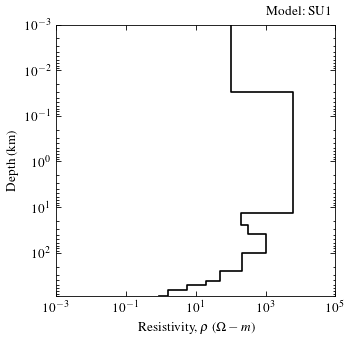

In [3]:
################################################################
# Create SU-1 Earth resistivity model and plot it with depth
################################################################
model_name = "SU1"
site = bezpy.mt.get_1d_site(model_name)
fig = plt.figure(dpi=120, figsize=(3,3))
ax = fig.add_subplot(111)
plot_resistivity(site, ax)

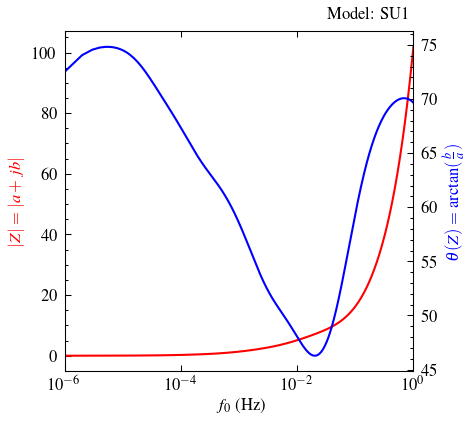

In [4]:
################################################################
# Estimate Earth surface impedance from 1D resistivity model 
# and plot it with frequency
################################################################
flim = 1e-6, 1e0
freqs = np.linspace(flim[0], flim[1], int(flim[1]/flim[0])+1)
Z = site.calcZ(freqs)[1,:]
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
plot_impedance_top_layer(site, Z, freqs, ax)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


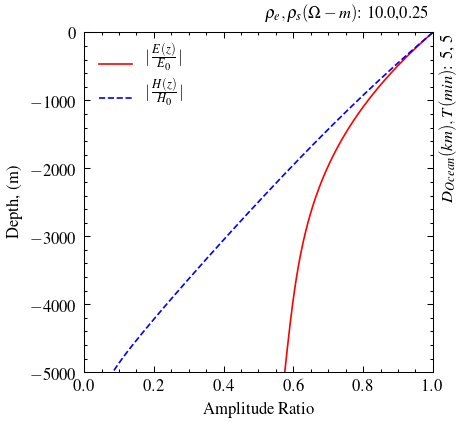

In [5]:
################################################################
# Estimate Hd/Ho and Ed/Eo for a fixed ocean depth, frequency 
# sea and seafloor resistivity
################################################################
H_ratio, E_ratio, z = calculate_E_B_ratios_sea_different_levels()
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
plot_E_B_ratios(H_ratio, E_ratio, z, ax)

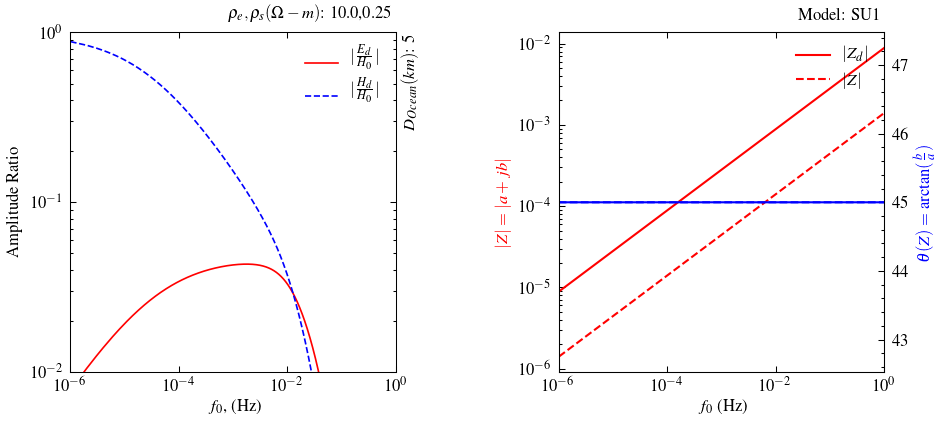

In [6]:
################################################################
# Variations in Hd/Ho and Ed/Ho for a fixed ocean depth, 
# sea and seafloor resistivity with frequency
################################################################
flim = 1e-6, 1e-0
freqs = np.linspace(flim[0], flim[1], int(flim[1]/flim[0])+1)
Ed2H0_ratio, Hd2H0_ratio, Zd, Z = calculate_EB_ratio_sea_surface2floor(freqs)
fig = plt.figure(dpi=150, figsize=(7,3))
ax = fig.add_subplot(121)
plot_EB_ratio_sea_surface2floor(freqs, Ed2H0_ratio, Hd2H0_ratio, ax)
ax = fig.add_subplot(122)
plot_Z_values(freqs, Zd, Z, ax)
fig.subplots_adjust(wspace=0.5, hspace=0.5)

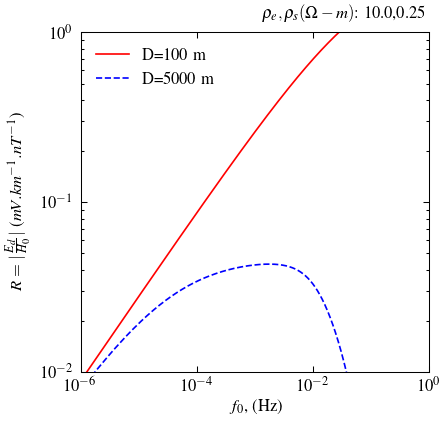

In [7]:
################################################################
# Variations in Ed/Ho for two different ocean depths, 
# and fixed sea and seafloor resistivity, with frequency
################################################################
flim = 1e-6, 1e-0
freqs = np.linspace(flim[0], flim[1], int(flim[1]/flim[0])+1)
Ed2H0_ratio_100m, _, _, _ = calculate_EB_ratio_sea_surface2floor(freqs, d=100)
Ed2H0_ratio_5000m, _, _, _ = calculate_EB_ratio_sea_surface2floor(freqs)
fig = plt.figure(dpi=150, figsize=(3,3))
ax = fig.add_subplot(111)
plot_ratios_sea_surface2floor(freqs, [Ed2H0_ratio_100m, Ed2H0_ratio_5000m], [100, 5000], ax)

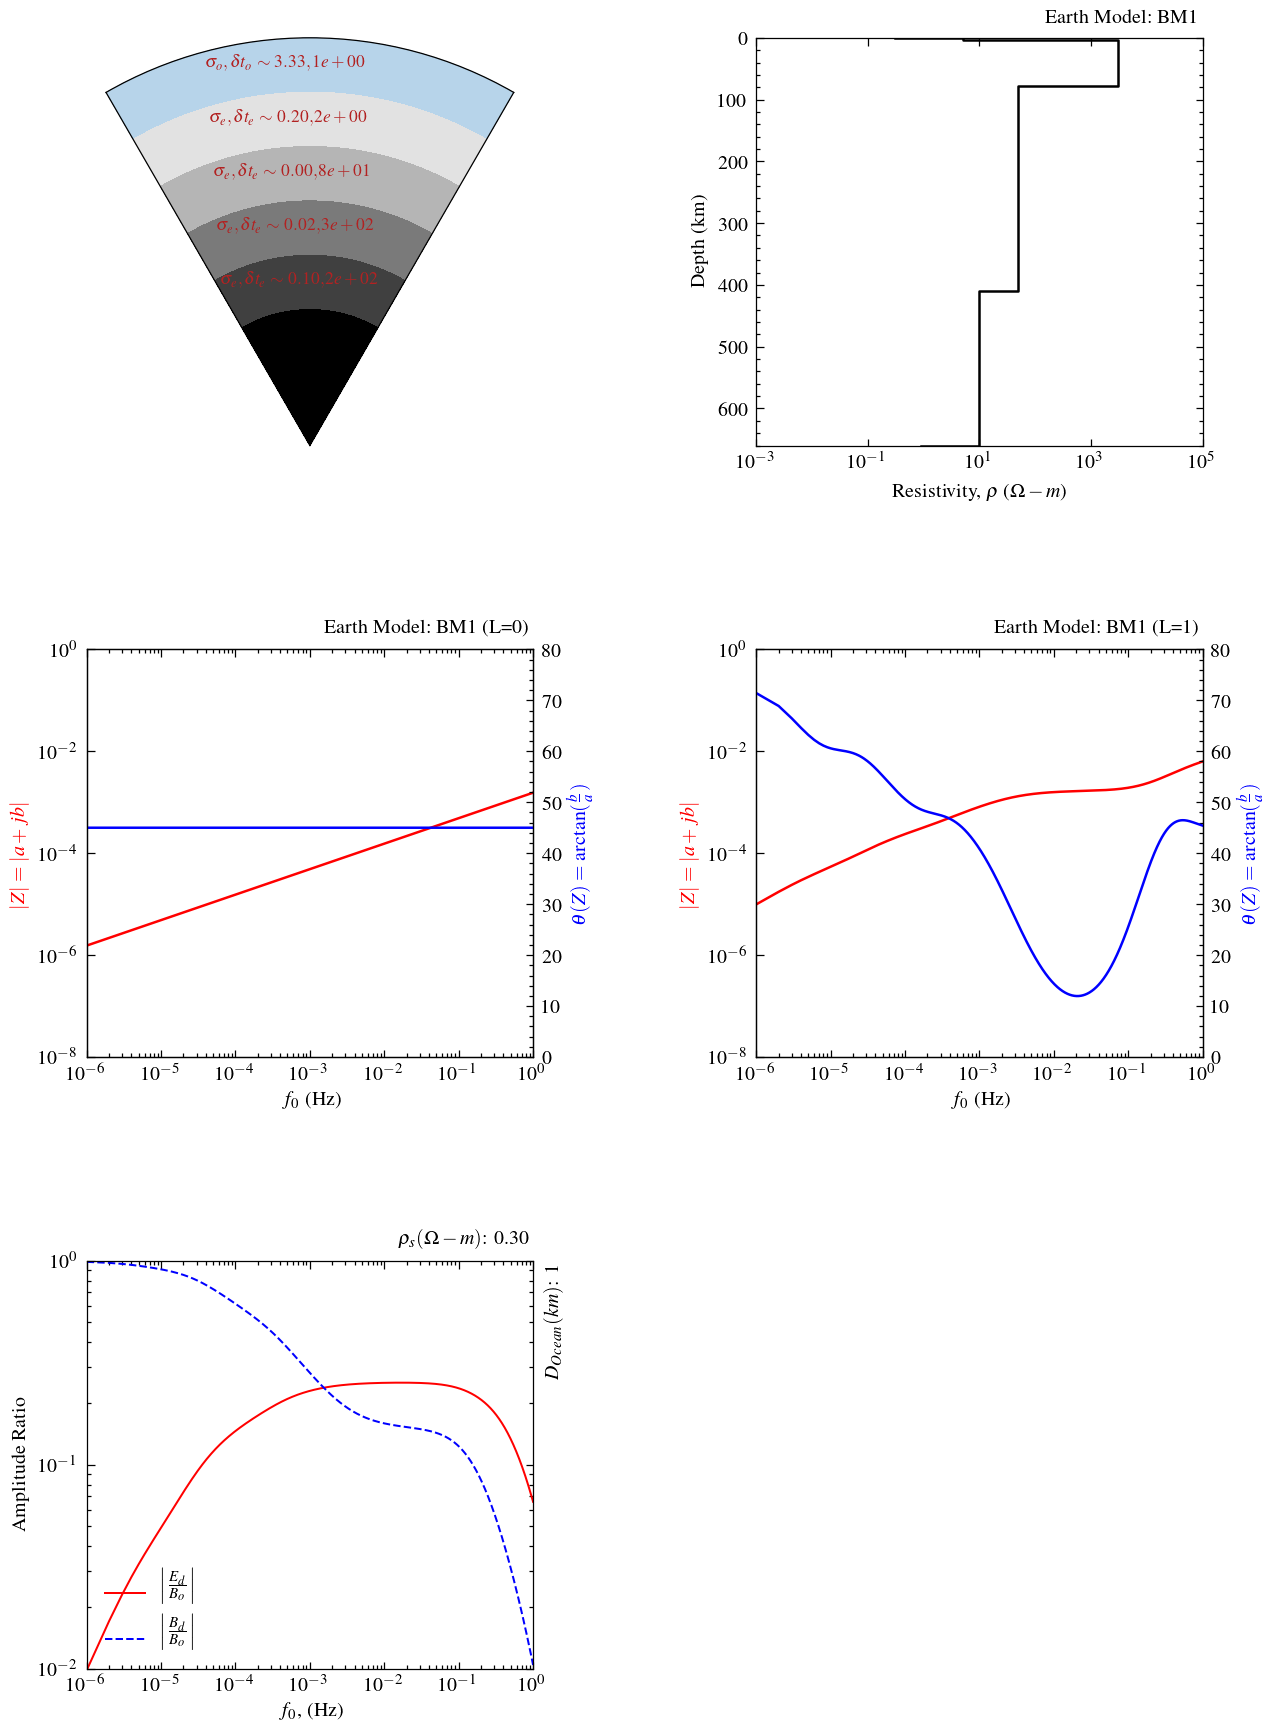

In [8]:
# Import 1D sea-earth model
from models import LayeredOcean
lo = LayeredOcean(model_name="BM1")
fig = plt.figure(dpi=180, figsize=(8, 12))
ax = fig.add_subplot(321, projection="polar")
lo.plot_earth_interior(ax, params={"thick":2.})
ax = fig.add_subplot(322)
lo.plot_resistivity(ax)
lo.plot_impedance(fig.add_subplot(323), layer=0)
lo.plot_impedance(fig.add_subplot(324), layer=1)
tf = lo.calcTF(ax=fig.add_subplot(325))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

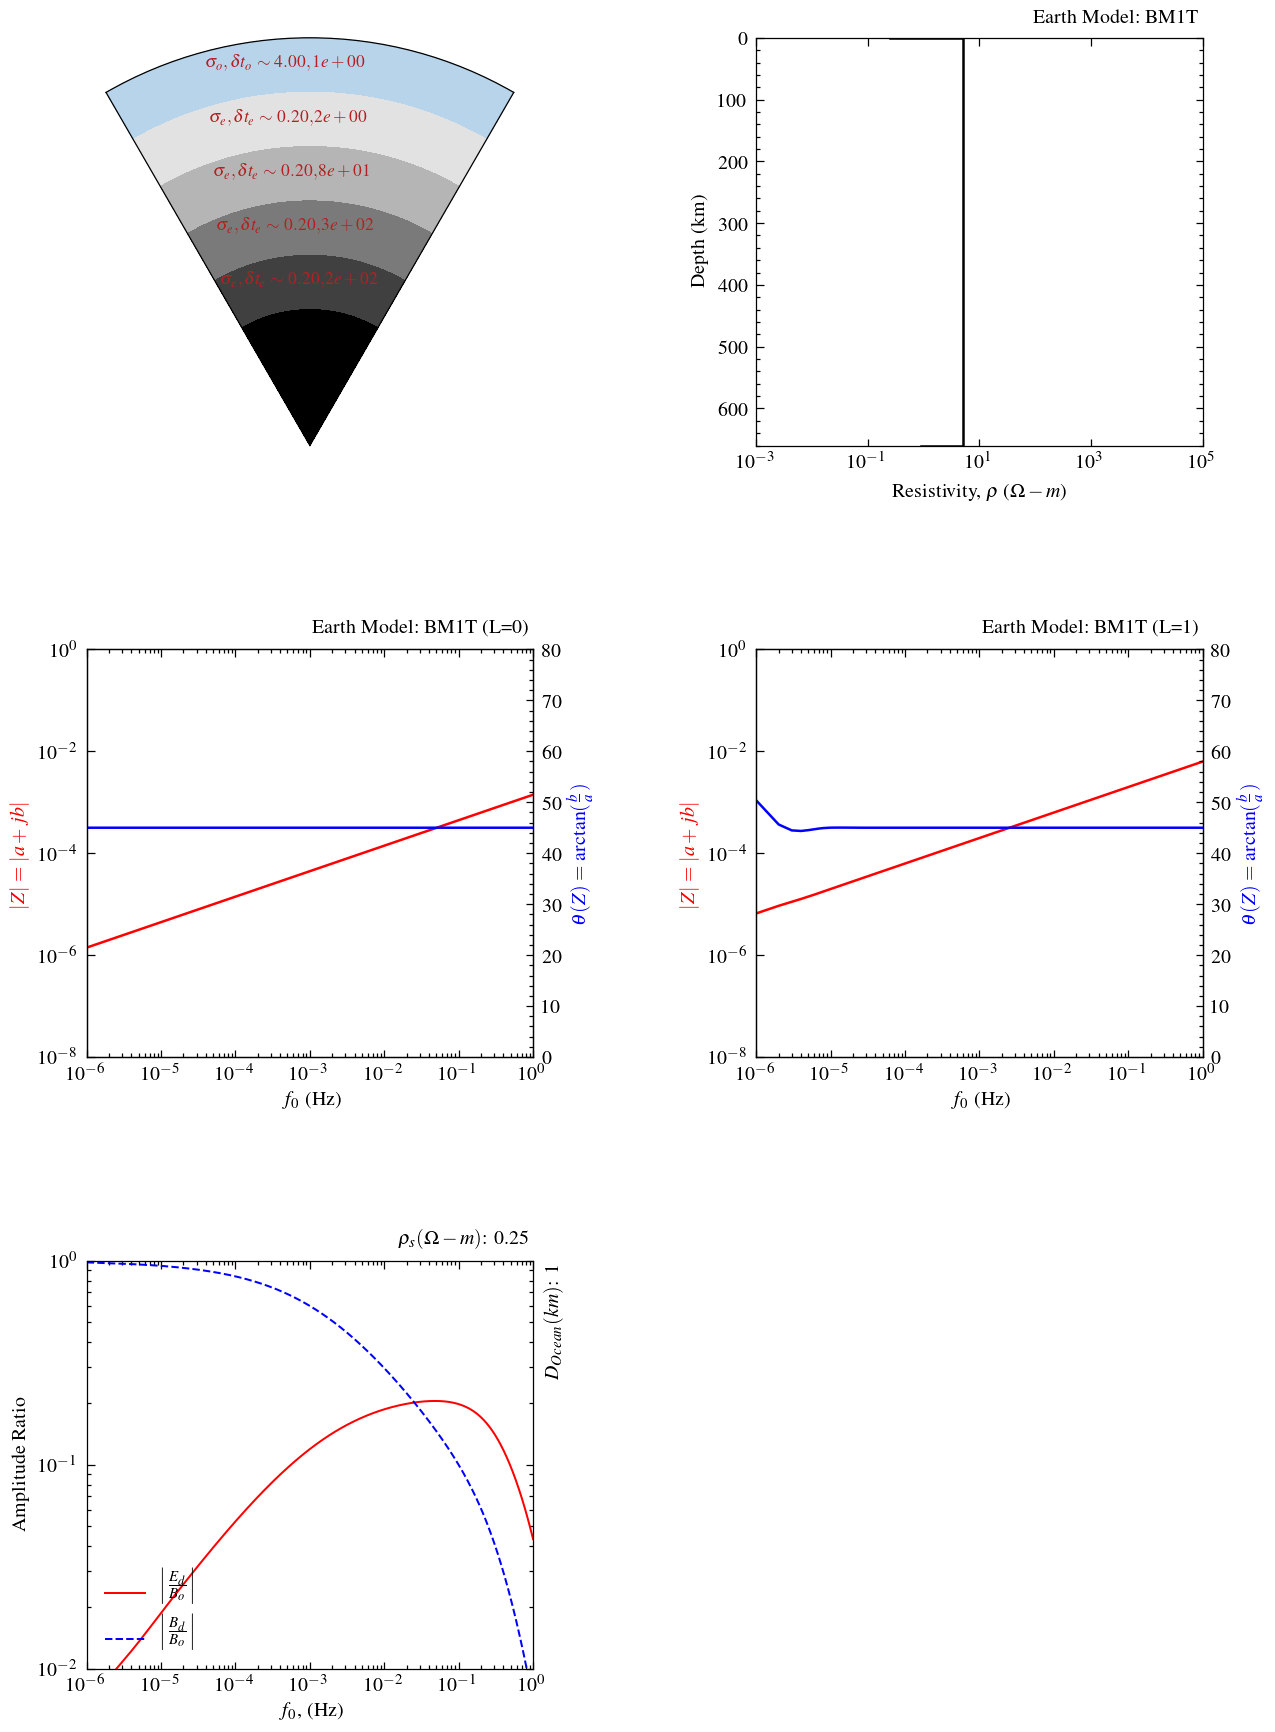

In [9]:
######################################################
# Test case - 1: Create Ben's test model with 
#                modified all the Earth's layer same
#                registivity values (uniform Earth).
######################################################
lo = LayeredOcean(model_name="BM1T")
fig = plt.figure(dpi=180, figsize=(8, 12))
ax = fig.add_subplot(321, projection="polar")
lo.plot_earth_interior(ax, params={"thick":2.})
ax = fig.add_subplot(322)
lo.plot_resistivity(ax)
lo.plot_impedance(fig.add_subplot(323), layer=0)
lo.plot_impedance(fig.add_subplot(324), layer=1)
tf = lo.calcTF(ax=fig.add_subplot(325))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

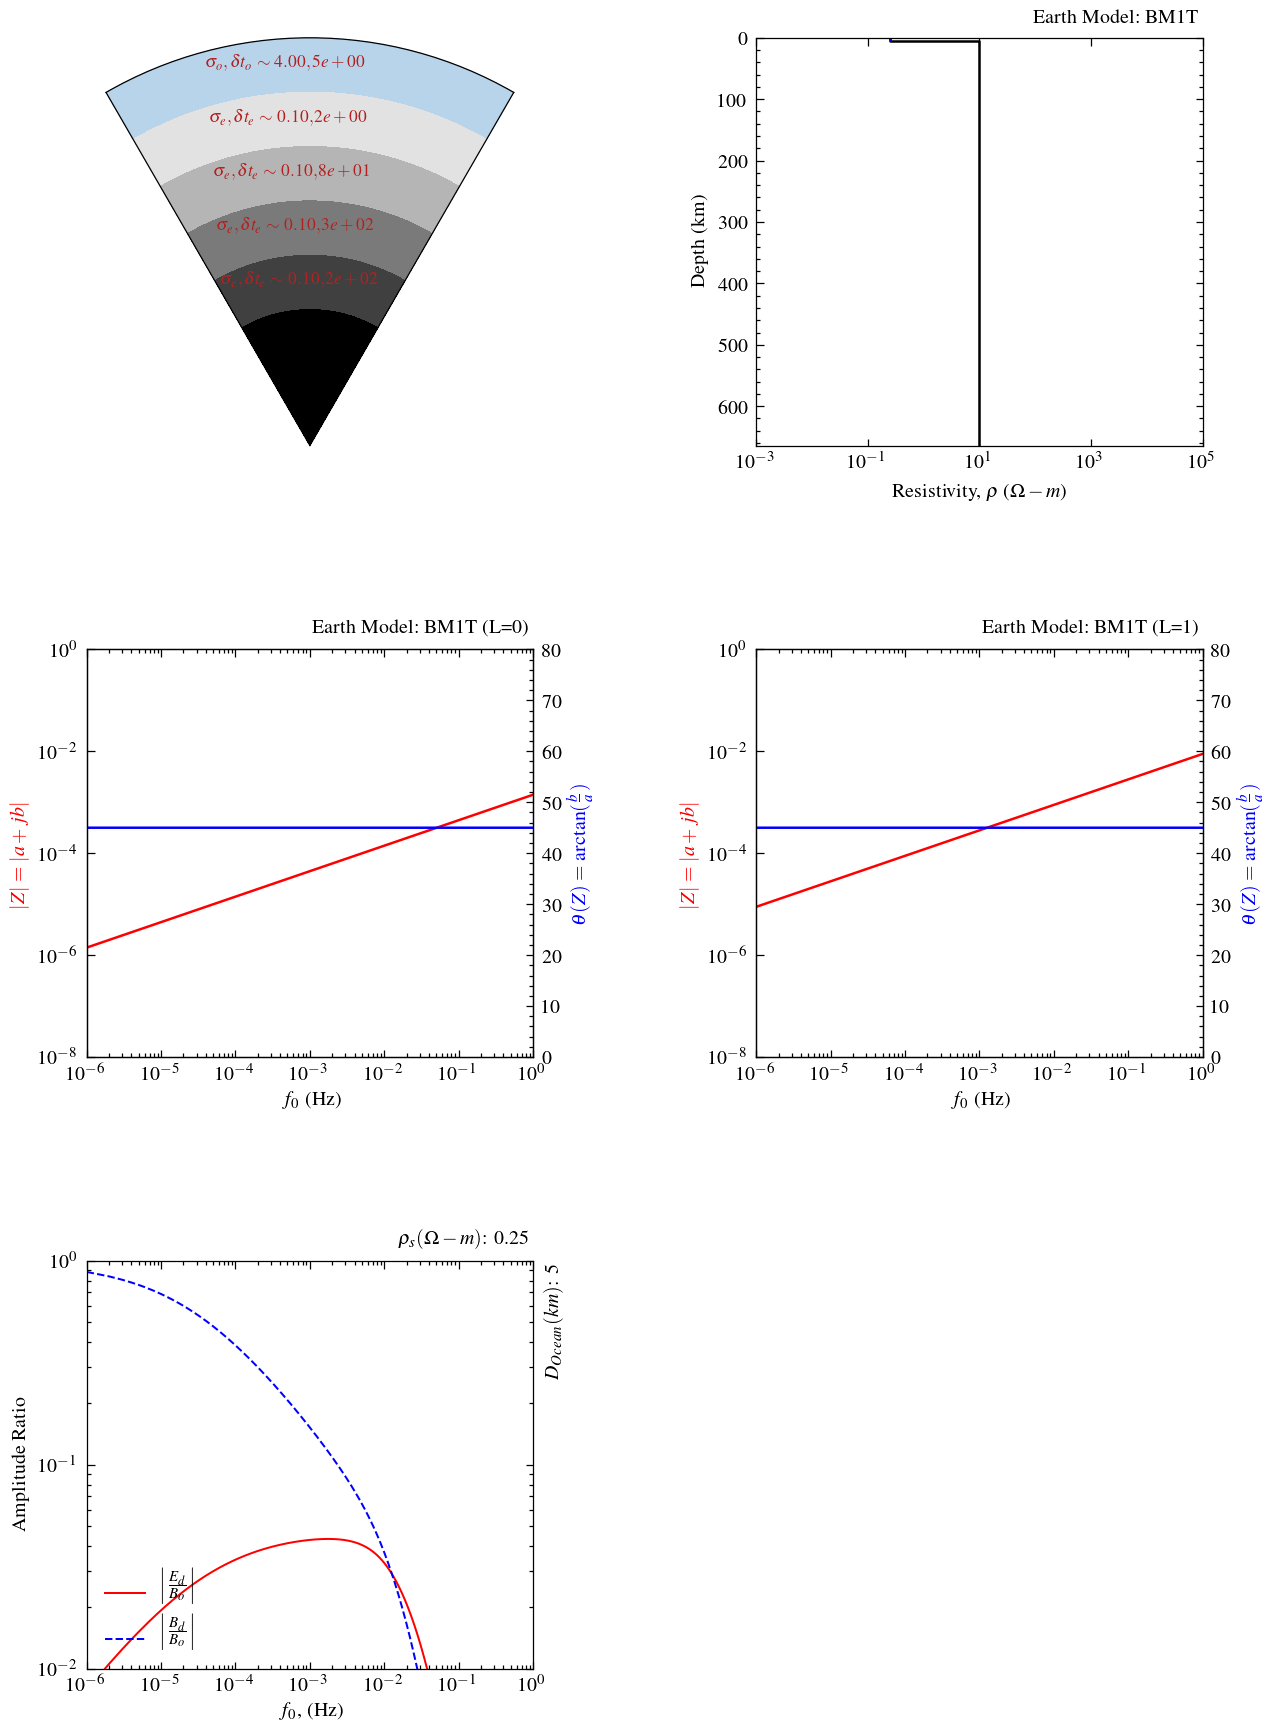

In [10]:
######################################################
# Test case - 2: Create Ben's test model with 
#                modified all the Earth's layer same
#                registivity values (uniform Earth)
#                and sea layer = 5km to replicate 
#                Boteler et al. (2003) results.
######################################################
lo = LayeredOcean(model_name="BM1T")
lo.thicknesses[0], lo.resistivities[1:] = 5e3, 10.*np.ones(len(lo.resistivities[1:]))
fig = plt.figure(dpi=180, figsize=(8, 12))
ax = fig.add_subplot(321, projection="polar")
lo.plot_earth_interior(ax, params={"thick":2.})
ax = fig.add_subplot(322)
lo.plot_resistivity(ax)
lo.plot_impedance(fig.add_subplot(323), layer=0)
lo.plot_impedance(fig.add_subplot(324), layer=1)
tf = lo.calcTF(ax=fig.add_subplot(325))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

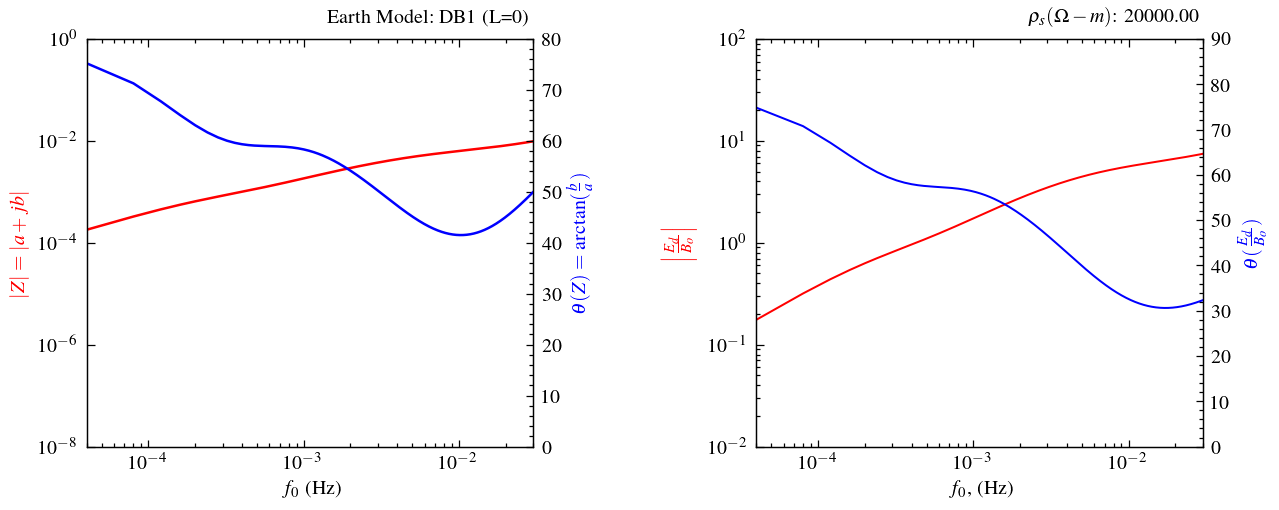

In [11]:
######################################################
# Test case - 3: Create Qubec model test model with 
#                modified all the layerd Earth
#                Boteler et al. (2019) results.
######################################################
lo = LayeredOcean(model_name="DB1", flim=[4e-5,3e-2])
fig = plt.figure(dpi=180, figsize=(8, 3))
lo.calcZ(ocean=False)
lo.plot_impedance(fig.add_subplot(121), layer=0)
lo.plotTFMagPhase(ax=fig.add_subplot(122), ylims=[1e-2,1e2], th=0)
fig.subplots_adjust(wspace=0.5, hspace=0.5)